<a href="https://colab.research.google.com/github/PaulMRivera/Computational_physics/blob/master/Evaluacion/Evaluacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
#Bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [125]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist
 
# Tomar la dirección URL del archivo en formato 'raw'
url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Eval1/data/co2_smo_DailyData.txt'
 
# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 151 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['site_code', 'year', 'month', 'day',
           'hour', 'minute', 'second', 'time_decimal', 
           'value', 'value_std_dev', 'nvalue', 'latitude', 'longitude', 'altitude',
           'elevation', 'intake_height', 'qcflag']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=151, skipfooter=1, engine='python')
 
# Hacemos una copia de trabajo y preservamos el dataframe original
df_work0 = df_dist.copy()
 
#Modificamos el valor : -999.99 por NaN
str_Nulo = -999.99
df_work1 = df_work0.replace(to_replace=str_Nulo, value='', regex=True)
 
cols_list = ['value']
for cols in cols_list:
  df_work1[cols] = pd.to_numeric(df_work1[cols], errors='coerce')
 
# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_work2 = df_work1.copy()
 
#Creamos una nueva columna con el nombre Fecha"
df_work2 = pd.DataFrame(df_work1, columns = ['year', 'month', 'day'])
df_work2['Fecha'] = pd.to_datetime(df_work2)
 
df_work3 =  df_work2[['Fecha','day']]

df_work3['day']=df_work1['value']

#Convierte el dataframe anterior a serie de tiempo 'ts_test', usando 'Fecha' como índice. 
df_work3= df_work3.set_index('Fecha')


# Fechas de inicio y fin, para filtrar la información

start, end = '1980-01-01', '2019-12-30'
ts_test = df_work3[start:end].copy()

ts_test.rename(columns={'day' : 'CO2'}, inplace=True)
ts_test.ffill(axis = 0, inplace=True)
ts_test

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,CO2
Fecha,
1980-01-01,337.25
1980-01-02,337.25
1980-01-03,337.56
1980-01-04,337.69
1980-01-05,337.83
...,...
2019-12-26,410.89
2019-12-27,410.89
2019-12-28,410.89


In [126]:
#Creamos una funcion para probar la estacionaridad de la serie de tiempo
def test_stationarity(df_ts):
  #Determina la estadistica de promedios moviles
  rolmean = df_ts.rolling(window=365,center=True).mean()
  rolstd= df_ts.rolling(window=365,center=True).std()

  #Define el tamaño de la figura 
  plt.rcParams['figure.figsize']=(12,6)
  #Graficando las estadisticas de los promedios moviles
  plt.plot(df_ts,color='b',label='Original')
  plt.plot(rolmean,color='red',label='Rolling mean')
  plt.plot(rolstd,color='green',label='Rolling std deviation')

  plt.legend(loc='best')
  plt.title('Promedio movil y desviacion estandar')
  plt.grid()
  plt.show()

  #Realizara la prueba aumentada de dickey -fuller
  print('Resultados de la prueba de Dickey-Fuller: ')
  dftest = adfuller(df_ts , autolag='AIC')
  dfoutput = pd.Series(dftest[0:4],index=['Test Statistic','p-value',
                                          '#Lags Used','Number of Observatons Used'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]= value
  print(dfoutput)

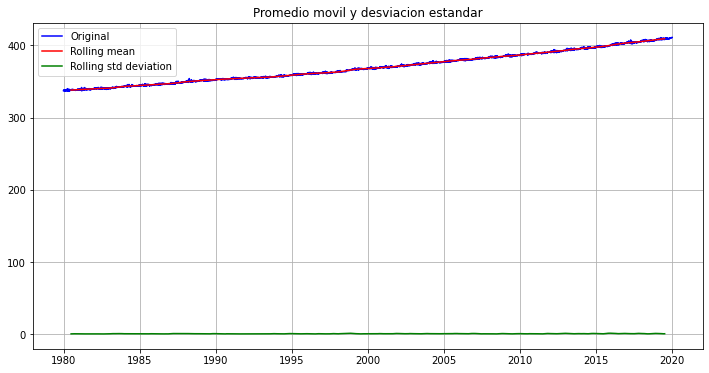

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    1.350431
p-value                           0.996877
#Lags Used                       39.000000
Number of Observatons Used    14569.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [133]:
#PROBAMOS ESTACIONARIDAD

test_stationarity(ts_test['CO2'])

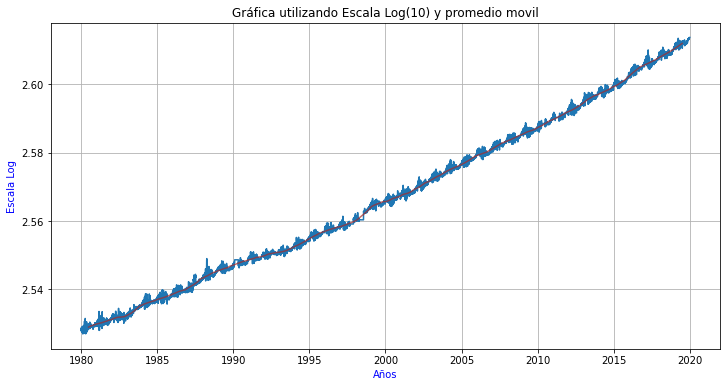

In [134]:
#Como no es estacionaria cambialos la escala
ts_test_log = np.log10(ts_test)
moving_avg = ts_test_log.rolling(365,center=True).mean()
plt.plot(ts_test_log)
plt.plot(moving_avg, color = 'brown',alpha=0.7)
plt.xlabel('Años',color='b')
plt.ylabel('Escala Log',color='b')
plt.title('Gráfica utilizando Escala Log(10) y promedio movil')
plt.grid()
plt.show()

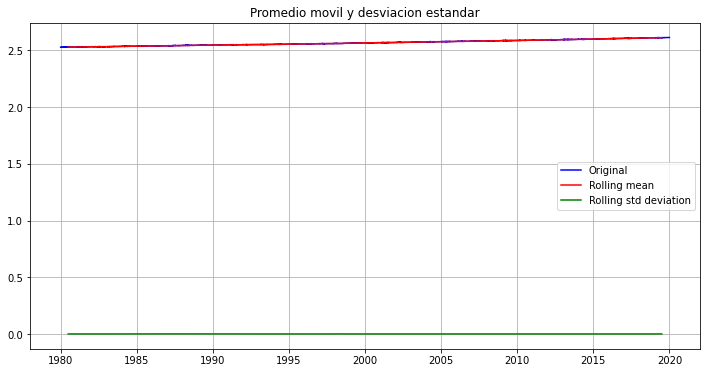

Resultados de la prueba de Dickey-Fuller: 
Test Statistic                    0.852495
p-value                           0.992438
#Lags Used                       35.000000
Number of Observatons Used    14573.000000
Critical Value(1%)               -3.430799
Critical Value(5%)               -2.861738
Critical Value(10%)              -2.566876
dtype: float64


In [135]:
test_stationarity(ts_test_log['CO2'])

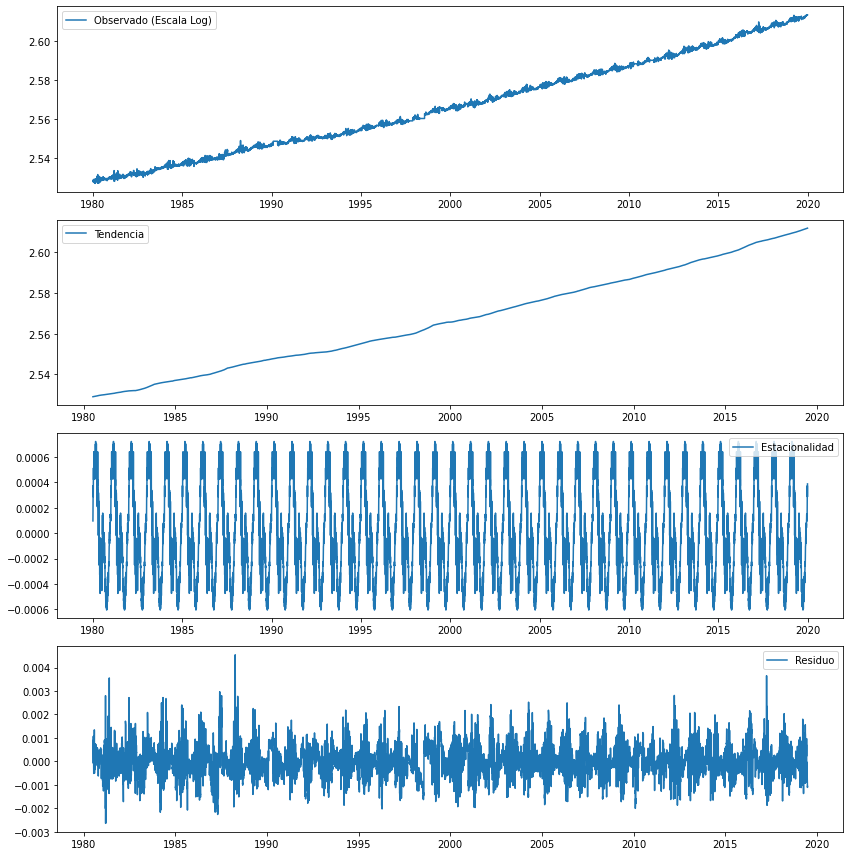

In [136]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test_log.interpolate(),
                                          model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test_log, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout()

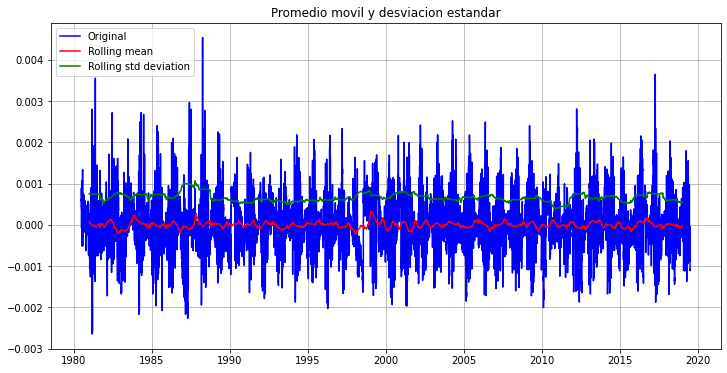

Resultados de la prueba de Dickey-Fuller: 
Test Statistic               -1.816493e+01
p-value                       2.455691e-30
#Lags Used                    2.100000e+01
Number of Observatons Used    1.422300e+04
Critical Value(1%)           -3.430810e+00
Critical Value(5%)           -2.861743e+00
Critical Value(10%)          -2.566878e+00
dtype: float64


In [137]:
ts_test_log_decompose = residue 
ts_test_log_decompose.dropna(inplace=True)
ts_test_log_decompose .head()
test_stationarity(ts_test_log_decompose['CO2'])

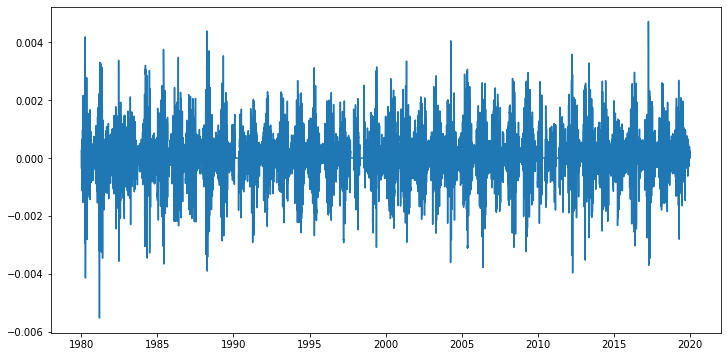

In [139]:
# Diferenciamos usando la función df.shift()
ts_test_log_diff = ts_test_log - ts_test_log.shift(periods=7)
ts_test_log_diff .dropna(inplace=True)
plt.plot(ts_test_log_diff)

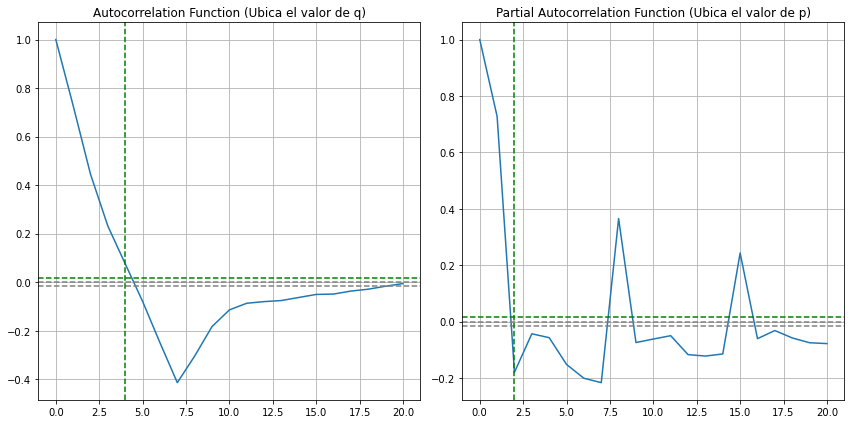

In [140]:
# Aplicamos ARIMA

lag_acf = acf(ts_test_log_diff, nlags=20)
lag_pacf = pacf(ts_test_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test_log_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(2, 1, 0)   Log Likelihood               92538.452
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -185068.905
Time:                        07:27:51   BIC                        -185038.547
Sample:                    01-02-1980   HQIC                       -185058.820
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.867e-06   3.09e-06      1.897      0.058   -1.94e-07    1.19e-05
ar.L1.D.CO2    -0.0003      0.008     -0.033      0.974      -0.016       0.016
ar.L2.D.CO2    -0.1478      0.008    -18.062    

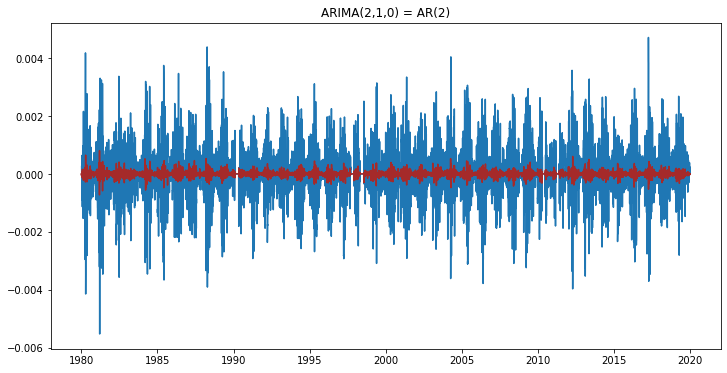

In [141]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(0, 1, 4)   Log Likelihood               93050.552
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186089.103
Time:                        07:28:06   BIC                        -186043.567
Sample:                    01-02-1980   HQIC                       -186073.975
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.847e-06   1.02e-06      5.720      0.000    3.84e-06    7.85e-06
ma.L1.D.CO2    -0.0998      0.008    -12.143      0.000      -0.116      -0.084
ma.L2.D.CO2    -0.2501      0.008    -30.692    

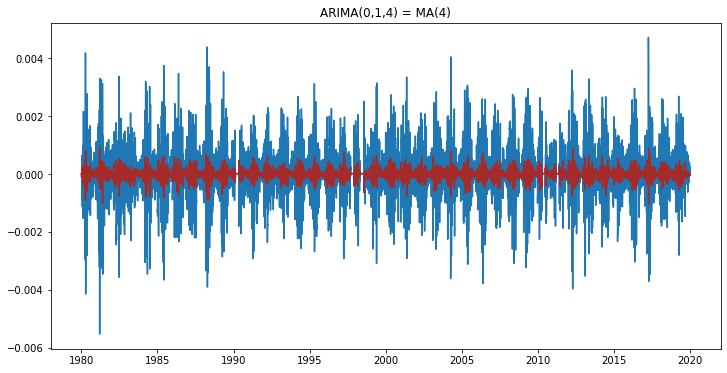

In [142]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))


                             ARIMA Model Results                              
Dep. Variable:                  D.CO2   No. Observations:                14608
Model:                 ARIMA(2, 1, 4)   Log Likelihood               93152.287
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 25 Feb 2021   AIC                        -186288.575
Time:                        07:28:39   BIC                        -186227.860
Sample:                    01-02-1980   HQIC                       -186268.405
                         - 12-30-2019                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.845e-06   7.54e-07      7.756      0.000    4.37e-06    7.32e-06
ar.L1.D.CO2     0.2368        nan        nan        nan         nan         nan
ar.L2.D.CO2     0.2229        nan        nan    

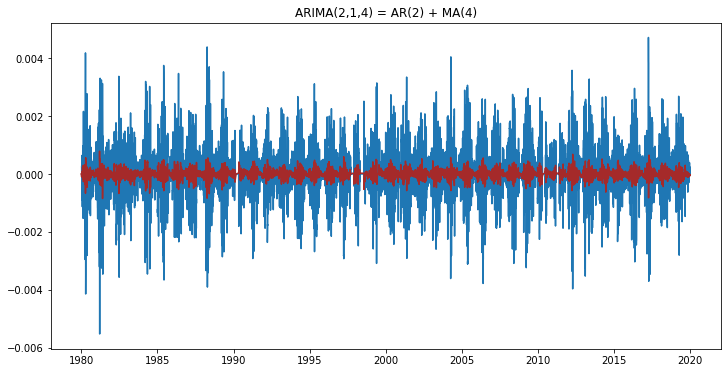

In [143]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

In [144]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
1980-01-02    0.000006
1980-01-03    0.000006
1980-01-04    0.000011
1980-01-05   -0.000052
1980-01-06   -0.000080
                ...   
2019-12-26   -0.000039
2019-12-27   -0.000034
2019-12-28   -0.000030
2019-12-29   -0.000026
2019-12-30   -0.000023
Length: 14608, dtype: float64


In [148]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_test_log['CO2'], index = ts_test_log.index)

predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print('Ts_test:')
print(ts_test_log.head())
print('Predictions_Arima_log')
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Ts_test:
                 CO2
Fecha               
1980-01-01  2.527952
1980-01-02  2.527952
1980-01-03  2.528351
1980-01-04  2.528518
1980-01-05  2.528698
Predictions_Arima_log
Fecha
1980-01-01         NaN
1980-01-02    2.527958
1980-01-03    2.528357
1980-01-04    2.528529
1980-01-05    2.528646
dtype: float64
Fecha
2019-12-26    2.613687
2019-12-27    2.613691
2019-12-28    2.613695
2019-12-29    2.613699
2019-12-30    2.613703
dtype: float64


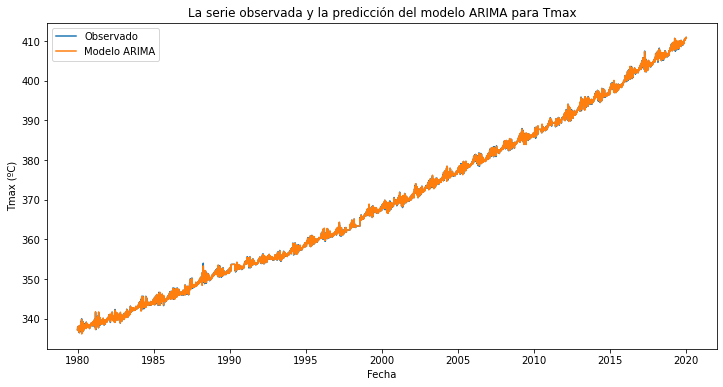

In [149]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best')

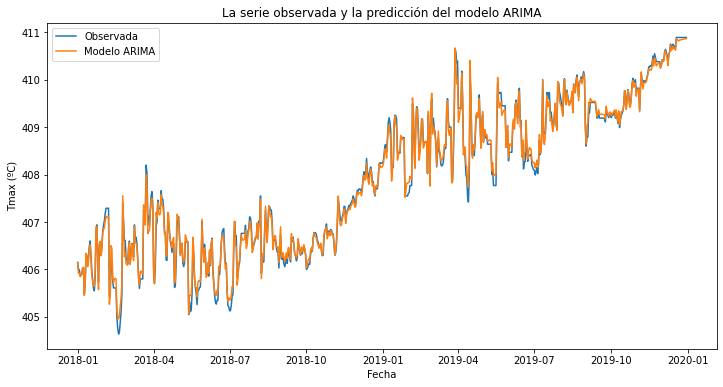

In [150]:
# Graficamos sólo los útimos datos de las series 
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best')